In [1]:
%load_ext autoreload
%autoreload 2

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.backends.backend_pdf import PdfPages
import math
import time
from io import StringIO
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from dataset import *
from torch.utils.data import DataLoader

In [3]:
torch.__version__

'1.6.0+cu101'

In [4]:
np.set_printoptions(threshold=sys.maxsize, suppress=True)
torch.set_printoptions(threshold=sys.maxsize, sci_mode=False)

In [5]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print (device)

cuda:2


In [6]:
torch.set_printoptions(sci_mode=False)

In [7]:
root_folder = 'data/simple_reacher/training'
number_of_trajectories = 5000
batch_size = 32

In [39]:
root_folder = 'data/simple_reacher/sample_data_all_limited_joints'
number_of_trajectories = 5

In [7]:
start = time.time()
base = SimpleReacherBaseDataset(root_folder, number_of_trajectories, device)
print ("Time Taken: {} sec".format(time.time() - start))

Time Taken: 4.342281341552734 sec


In [41]:
start = time.time()
ondemand = SimpleReacherOnDemandDataset(root_folder, number_of_trajectories)
print ("Time Taken: {} sec".format(time.time() - start))

Time Taken: 0.07968378067016602 sec


In [5]:
start = time.time()
preloaded = SimpleReacherPreLoadedDataset(root_folder, number_of_trajectories)
print ("Time Taken: {} sec".format(time.time() - start))

Time Taken: 10.221627950668335 sec


In [7]:
start = time.time()
train_data = SimpleReacherOnDemandDataset(root_folder, range(4750), device=None)
test_data = SimpleReacherOnDemandDataset(root_folder, range(4750, 5000), device=None)
print ("Time Taken: {} sec".format(time.time() - start))

Time Taken: 21.97927212715149 sec


In [7]:
train_data = SimpleReacherOnDemandDataset(root_folder, range(5000), device=device)

In [8]:
print (train_data.trajectory_data.shape)

torch.Size([108673, 9])


In [9]:
print (torch.min(train_data.trajectory_data[:, :1]))
print (torch.max(train_data.trajectory_data[:, :1]))
print (torch.min(train_data.trajectory_data[:, 1:3]))
print (torch.max(train_data.trajectory_data[:, 1:3]))
print (torch.min(train_data.trajectory_data[:, 3:6]))
print (torch.max(train_data.trajectory_data[:, 3:6]))
print (torch.min(train_data.trajectory_data[:, 6:]))
print (torch.max(train_data.trajectory_data[:, 6:]))
# print (torch.min(test_data.trajectory_data[:, :3]))
# print (torch.max(test_data.trajectory_data[:, :3]))
# print (torch.min(test_data.trajectory_data[:, 3:6]))
# print (torch.max(test_data.trajectory_data[:, 3:6]))
# print (torch.min(test_data.trajectory_data[:, 6:]))
# print (torch.max(test_data.trajectory_data[:, 6:]))
print (np.pi)

tensor(-3.1352, device='cuda:2', dtype=torch.float64)
tensor(3.1405, device='cuda:2', dtype=torch.float64)
tensor(-2.8946, device='cuda:2', dtype=torch.float64)
tensor(2.8969, device='cuda:2', dtype=torch.float64)
tensor(-3.1364, device='cuda:2', dtype=torch.float64)
tensor(3.1412, device='cuda:2', dtype=torch.float64)
tensor(-0.1990, device='cuda:2', dtype=torch.float64)
tensor(0.1985, device='cuda:2', dtype=torch.float64)
3.141592653589793


In [10]:
actions = train_data.trajectory_data[:, 6:]
print (actions.shape)
print (torch.max(actions))
print (torch.min(actions))
print (torch.where(torch.abs(actions) <= 0.15)[0].shape)
print (torch.where(torch.abs(actions) > 0.15)[0].shape)
print (torch.unique(torch.where(actions > 0.15)[0]))

torch.Size([108673, 3])
tensor(0.1985, device='cuda:2', dtype=torch.float64)
tensor(-0.1990, device='cuda:2', dtype=torch.float64)
torch.Size([325294])
torch.Size([725])
tensor([  3035,   3036,   3037,   3038,   3039,   3040,   3041,   3042,   4013,
          4014,   4015,   7230,   7768,   7769,   7770,   8058,   8059,   8060,
          8061,   8062,   8063,   8064,   8065,   8066,   8067,   8820,   8821,
          8822,   8823,   8824,  10450,  10451,  10452,  10453,  10454,  10455,
         10506,  10507,  10508,  10509,  10510,  10511,  10656,  10657,  10658,
         10659,  10660,  10661,  10662,  10696,  10697,  10698,  10699,  10700,
         12483,  12484,  12485,  12486,  13834,  13835,  14230,  14231,  14232,
         15638,  15639,  15640,  15641,  15784,  15785,  15786,  15787,  18005,
         18006,  18007,  18008,  18009,  18010,  18011,  19591,  19592,  19593,
         19594,  19595,  19596,  19597,  20891,  20892,  20893,  20894,  20895,
         20896,  20897,  20910

In [38]:
train_data.cumulative_index

tensor([        0.,        24.,        51.,  ...,    108597.,    108627.,
           108648.])

In [40]:
import bisect
rowId = 51
pos = bisect.bisect_left(train_data.cumulative_index.numpy(), rowId)
if train_data.cumulative_index[pos] < rowId:
    pos -= 1
print ('Trajectory containing row index : {} = {}'.format(rowId, pos))

Trajectory containing row index : 51 = 2


In [29]:
def trajectory_goal_error(trajectory):
    return torch.abs(trajectory[-1, :3]-trajectory[-1, 3:6])

In [30]:
traj_errors = torch.zeros(5000, 3)
for i in range(5000):
    traj_errors[i] = trajectory_goal_error(train_data.trajectory_data[torch.where(train_data.trajectory_index[:, 0] == i)[0]])

In [16]:
trajectory = train_data.trajectory_data[torch.where(train_data.trajectory_index == 0)[0]]

In [17]:
print (trajectory[-1, :3])
print (trajectory[-1, 3:6])
print (trajectory_goal_error(trajectory))

tensor([-2.9732, -1.6935, -1.9150], device='cuda:2', dtype=torch.float64)
tensor([-1.0334,  0.0324, -2.4570], device='cuda:2', dtype=torch.float64)
tensor([1.9398, 1.7259, 0.5420], device='cuda:2', dtype=torch.float64)


In [31]:
print(torch.min(traj_errors))
print(torch.max(traj_errors))
print (torch.where(traj_errors > 0.1)[0])
# print (traj_errors[torch.where(traj_errors > 0.15)[0]])

tensor(    0.0000)
tensor(0.0995)
tensor([], dtype=torch.int64)


In [6]:
traj_dataset = SimpleReacherTrajectoryDataset(root_folder, number_of_trajectories, include_images=False, device=device)

In [33]:
for tId in range(5000):
    tData = traj_dataset[tId]['states']
    state_diff = (tData[1:, :3] - tData[:-1, :3])
    if torch.any(torch.abs(state_diff) > 0.1):
        print (tId)
print ('Done')

Done


In [31]:
tData = traj_dataset[1]['states']
state_diff = (tData[1:, :3] - tData[:-1, :3])
torch.abs(state_diff)

tensor([[0.0519, 0.0637, 0.0305],
        [0.0166, 0.0308, 0.0562],
        [0.0227, 0.0423, 0.0815],
        [0.0228, 0.0426, 0.0839],
        [0.0228, 0.0427, 0.0844],
        [0.0228, 0.0427, 0.0845],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846]], device='cuda:2', dtype=torch.float64)

In [6]:
start = time.time()
train_traj_data = SimpleReacherTrajectoryDataset(root_folder, range(500), device=device) #only a subset of training_data
test_traj_data = SimpleReacherTrajectoryDataset(root_folder, range(4750, 5000), device=device)
print ("Time Taken: {} sec".format(time.time() - start))

Time Taken: 9.918212890625e-05 sec


In [20]:
last_rows = torch.zeros((len(train_traj_data), 9))
other_rows = None
for i in range(len(train_traj_data)):
    last_rows[i] = train_traj_data[i]['states'][-1]
    if other_rows is not None:
        other_rows = torch.cat((other_rows, train_traj_data[i]['states'][:-1, :]), dim=0)
    else:
        other_rows = train_traj_data[i]['states'][:-1, :]

In [ ]:
last_rows_diff = (last_rows[:, 3:6] - last_rows[:, :3]).cpu()
other_rows_diff = (other_rows[:, 3:6] - other_rows[:, :3]).cpu()

In [9]:
traj_dataset = SimpleReacherTrajectoryDataset(root_folder, range(10), device=device)

In [10]:
new_traj_dataset = SimpleReacherTrajectoryDataset('data/simple_reacher/ImageSize64', range(5), device=device)

In [11]:
traj_dataset[7]['images'].shape

torch.Size([40, 65536])

In [12]:
new_traj_dataset[0]['images'].shape

torch.Size([11, 4096])

In [13]:
t7_last = traj_dataset[7]['images'][-1].reshape(256, 256)

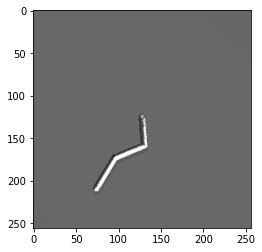

In [14]:
fig = plt.imshow(t7_last.cpu().numpy(), cmap='gray')
plt.savefig('Old.jpg')

In [15]:
last_row = traj_dataset[7]['states'][-1]
goal_dev = last_row[3:6] - last_row[:3]
print (goal_dev)
print (torch.sum(torch.abs(goal_dev)))

tensor([-0.0012, -0.0012,  0.0012], device='cuda:2', dtype=torch.float64)
tensor(0.0036, device='cuda:2', dtype=torch.float64)


In [20]:
new_t4_first = new_traj_dataset[4]['images'][0].reshape(64, 64)
new_t4_last = new_traj_dataset[4]['images'][-1].reshape(64, 64)

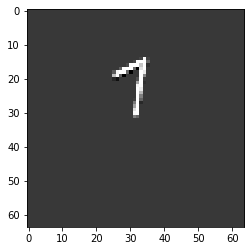

In [21]:
fig = plt.imshow(new_t4_last.cpu().numpy(), cmap='gray')

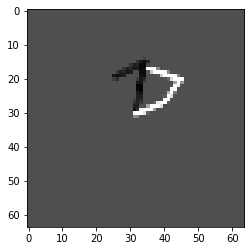

In [22]:
fig = plt.imshow(new_t4_first.cpu().numpy(), cmap='gray')

In [24]:
new_t4_first[20]

tensor([127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
        127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 115, 100, 127,
        127, 127, 127, 127, 114,  87, 100, 127, 127, 127, 127, 127, 127, 144,
        227, 255, 254, 255, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
        127, 127, 127, 127, 127, 127, 127, 127], device='cuda:2',
       dtype=torch.uint8)

In [30]:
new_t4_first[new_t4_first == 128]

tensor([], device='cuda:2', dtype=torch.uint8)

In [25]:
new_t4_first_filtered = torch.where(
    torch.bitwise_or(new_t4_first < 126, new_t4_first > 128),
    new_t4_first,
    torch.zeros_like(new_t4_first))

In [35]:
new_t4_first_np = new_t4_first.cpu().numpy()
new_t4_first_filtered_np = np.where(new_t4_first_np == 127, np.zeros_like(new_t4_first_np), new_t4_first_np)

In [38]:
np.all(new_t4_first_filtered_np == new_t4_first_filtered.cpu().numpy())

True

In [40]:
np.any(new_t4_first_np == 126) or np.any(new_t4_first_np == 128)

False

In [27]:
new_t4_first_filtered[20]

tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 115, 100,   0,
          0,   0,   0,   0, 114,  87, 100,   0,   0,   0,   0,   0,   0, 144,
        227, 255, 254, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0], device='cuda:2',
       dtype=torch.uint8)

In [28]:
new_t4_first_filtered

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   

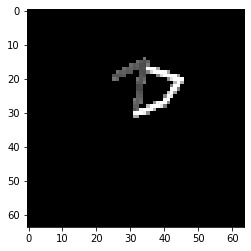

In [26]:
fig = plt.imshow(new_t4_first_filtered.cpu().numpy(), cmap='gray')

In [18]:
last_row = new_traj_dataset[4]['states'][-1]
goal_dev = last_row[3:6] - last_row[:3]
print (goal_dev)
print (torch.sum(torch.abs(goal_dev)))

tensor([ 0.0022, -0.0005,  0.0002], device='cuda:2', dtype=torch.float64)
tensor(0.0030, device='cuda:2', dtype=torch.float64)


In [123]:
new_t4_last_filtered = torch.where(
    torch.bitwise_or(new_t4_last < 136, new_t4_last > 138),
    new_t4_last,
    torch.zeros_like(new_t4_last))

In [124]:
t7_last_filtered = torch.where(
    torch.bitwise_or(t7_last < 136, t7_last > 138),
    t7_last,
    torch.zeros_like(t7_last))

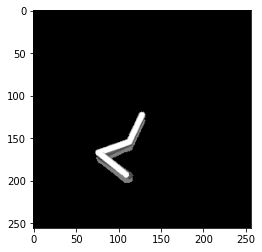

In [143]:
fig = plt.imshow(new_t4_last_filtered.cpu().numpy(), cmap='gray')
plt.savefig('New_BG_Cleared.jpg')

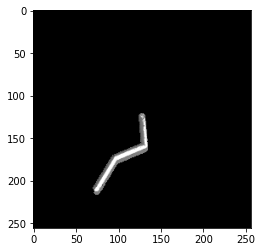

In [144]:
fig = plt.imshow(t7_last_filtered.cpu().numpy(), cmap='gray')
plt.savefig('Old_BG_Cleared.jpg')

In [137]:
def print_non_zero(ip_tensor):
    for i in range(len(ip_tensor)):
        if torch.sum(ip_tensor[i] > 0):
            print ('{}: {}'.format(i, ip_tensor[i][ip_tensor[i] != 0].cpu().numpy()))

In [138]:
print_non_zero(t7_last_filtered)

121: [100 128  96 120]
122: [130 104 146 146 179 134]
123: [117 103 183 118 151 147 175  94]
124: [ 90 105 148 186 187 148 103 129]
125: [103 104 147 255 221 219 105 141]
126: [101 100 111 115 188 148 180 122]
127: [ 96  99 111 115 155 114 218 203]
128: [ 89  97 110 115 121 184 255 210]
129: [106  94 110 115 155 220 218 220]
130: [ 96  93 109 114 155 185 182 220 124]
131: [ 90 108 114 122 185 255 227 128]
132: [ 87 108 114 121 150 255 233 125]
133: [ 89 108 113 119 151 255 241 140]
134: [ 77 106 112 118 152 255 243 146]
135: [ 90 104 112 118 119 148 248 177]
136: [ 86 104 112 117 121 183 252 168]
137: [ 97 102 111 116 155 255 254 210]
138: [ 92  99 111 115 156 255 255 202]
139: [ 85  97 110 115 155 255 255 214]
140: [ 86  95 110 115 188 220 255 222 103]
141: [101  95 109 114 155 255 255 221 125]
142: [ 95  91 108 114 122 220 255 228 129]
143: [127  88 108 114 122 220 255 237 128]
144: [ 84 108 114 120 220 255 242 141]
145: [ 87 107 113 119 186 255 243 148]
146: [ 90 105 112 118 187 255

In [139]:
print_non_zero(new_t4_last_filtered)

119: [113 103]
120: [139 226 250 249 226 135]
121: [131 228 255 255 255 255 230  69]
122: [164 247 255 255 255 255 255 151]
123: [107 220 255 255 255 255 255 253 169]
124: [162 245 255 255 255 255 255 236 122]
125: [103 216 255 255 255 255 255 253 204  81]
126: [154 242 255 255 255 255 255 239 132 116]
127: [103 212 255 255 255 255 255 254 210  63]
128: [143 239 255 255 255 255 255 243 135 107]
129: [217 255 255 255 255 255 255 217  83 127 127]
130: [133 236 255 255 255 255 255 242 141 109 127 127]
131: [214 255 255 255 255 255 255 215  78 127 127]
132: [127 233 255 255 255 255 255 245 148  91 127 127]
133: [180 254 255 255 255 255 255 220  75 127 127 127]
134: [235 255 255 255 255 255 249 158  74 127 127]
135: [176 253 255 255 255 255 255 224  86 103 127 127]
136: [134 231 255 255 255 255 255 251 161  75 127 127]
137: [171 252 255 255 255 255 255 228  92 106 127 127]
138: [132 227 255 255 255 255 255 253 198  77 127 127]
139: [167 251 255 255 255 255 255 235 105 107 127 127]
140: [131

In [42]:
root = 'data/simple_reacher/ImageSize64_ClearBG'
count = 0
for i in range(1000):
    filePath = os.path.join(root, str(i), 'images.npy')
    ip = np.load(filePath)
    if np.any(ip == 126) or np.any(ip == 128):
        print ('Adjacent elements are detected in trajectory {}, further look needed'.format(i))
    op = np.where(ip == 127, np.zeros_like(ip), ip)
    np.save(filePath, op)
    count += 1
print ('Total files processed = {}'.format(count))

Adjacent elements are detected in trajectory 0, further look needed
Adjacent elements are detected in trajectory 1, further look needed
Adjacent elements are detected in trajectory 2, further look needed
Adjacent elements are detected in trajectory 3, further look needed
Adjacent elements are detected in trajectory 4, further look needed
Adjacent elements are detected in trajectory 5, further look needed
Adjacent elements are detected in trajectory 6, further look needed
Adjacent elements are detected in trajectory 7, further look needed
Adjacent elements are detected in trajectory 8, further look needed
Adjacent elements are detected in trajectory 9, further look needed
Adjacent elements are detected in trajectory 10, further look needed
Adjacent elements are detected in trajectory 11, further look needed
Adjacent elements are detected in trajectory 12, further look needed
Adjacent elements are detected in trajectory 13, further look needed
Adjacent elements are detected in trajectory

Adjacent elements are detected in trajectory 155, further look needed
Adjacent elements are detected in trajectory 156, further look needed
Adjacent elements are detected in trajectory 157, further look needed
Adjacent elements are detected in trajectory 158, further look needed
Adjacent elements are detected in trajectory 159, further look needed
Adjacent elements are detected in trajectory 160, further look needed
Adjacent elements are detected in trajectory 161, further look needed
Adjacent elements are detected in trajectory 162, further look needed
Adjacent elements are detected in trajectory 163, further look needed
Adjacent elements are detected in trajectory 164, further look needed
Adjacent elements are detected in trajectory 165, further look needed
Adjacent elements are detected in trajectory 166, further look needed
Adjacent elements are detected in trajectory 167, further look needed
Adjacent elements are detected in trajectory 168, further look needed
Adjacent elements ar

Adjacent elements are detected in trajectory 339, further look needed
Adjacent elements are detected in trajectory 340, further look needed
Adjacent elements are detected in trajectory 341, further look needed
Adjacent elements are detected in trajectory 342, further look needed
Adjacent elements are detected in trajectory 343, further look needed
Adjacent elements are detected in trajectory 344, further look needed
Adjacent elements are detected in trajectory 345, further look needed
Adjacent elements are detected in trajectory 346, further look needed
Adjacent elements are detected in trajectory 347, further look needed
Adjacent elements are detected in trajectory 348, further look needed
Adjacent elements are detected in trajectory 349, further look needed
Adjacent elements are detected in trajectory 350, further look needed
Adjacent elements are detected in trajectory 351, further look needed
Adjacent elements are detected in trajectory 352, further look needed
Adjacent elements ar

Adjacent elements are detected in trajectory 539, further look needed
Adjacent elements are detected in trajectory 540, further look needed
Adjacent elements are detected in trajectory 541, further look needed
Adjacent elements are detected in trajectory 542, further look needed
Adjacent elements are detected in trajectory 543, further look needed
Adjacent elements are detected in trajectory 544, further look needed
Adjacent elements are detected in trajectory 545, further look needed
Adjacent elements are detected in trajectory 546, further look needed
Adjacent elements are detected in trajectory 547, further look needed
Adjacent elements are detected in trajectory 548, further look needed
Adjacent elements are detected in trajectory 549, further look needed
Adjacent elements are detected in trajectory 550, further look needed
Adjacent elements are detected in trajectory 551, further look needed
Adjacent elements are detected in trajectory 552, further look needed
Adjacent elements ar

Adjacent elements are detected in trajectory 733, further look needed
Adjacent elements are detected in trajectory 734, further look needed
Adjacent elements are detected in trajectory 735, further look needed
Adjacent elements are detected in trajectory 736, further look needed
Adjacent elements are detected in trajectory 737, further look needed
Adjacent elements are detected in trajectory 738, further look needed
Adjacent elements are detected in trajectory 739, further look needed
Adjacent elements are detected in trajectory 740, further look needed
Adjacent elements are detected in trajectory 741, further look needed
Adjacent elements are detected in trajectory 742, further look needed
Adjacent elements are detected in trajectory 743, further look needed
Adjacent elements are detected in trajectory 744, further look needed
Adjacent elements are detected in trajectory 745, further look needed
Adjacent elements are detected in trajectory 746, further look needed
Adjacent elements ar

Adjacent elements are detected in trajectory 921, further look needed
Adjacent elements are detected in trajectory 922, further look needed
Adjacent elements are detected in trajectory 923, further look needed
Adjacent elements are detected in trajectory 924, further look needed
Adjacent elements are detected in trajectory 925, further look needed
Adjacent elements are detected in trajectory 926, further look needed
Adjacent elements are detected in trajectory 927, further look needed
Adjacent elements are detected in trajectory 928, further look needed
Adjacent elements are detected in trajectory 929, further look needed
Adjacent elements are detected in trajectory 930, further look needed
Adjacent elements are detected in trajectory 931, further look needed
Adjacent elements are detected in trajectory 932, further look needed
Adjacent elements are detected in trajectory 933, further look needed
Adjacent elements are detected in trajectory 934, further look needed
Adjacent elements ar

In [44]:
def process_arrays(root, total, fileName, array_func, save=False):
    for tId in range(total):
        filePath = os.path.join(root, str(tId), fileName)
        ip = np.load(filePath)
        op = array_func(tId, ip)
        if save:
            np.save(filePath, op)

In [53]:
filtered = []
def filter_arrays(tId, arr):
    if np.any(arr == 128):
        filtered.append(tId)

process_arrays('data/simple_reacher/ImageSize64_ClearBG', 1000, 'images.npy', array_func = filter_arrays, save=False)

In [54]:
len(filtered)

993

In [76]:
def save_trajectory_video(labels, targetFile, img_H, img_W):
    ims = []
    fig = plt.figure()
    for i in range(len(labels)):
        im1 = plt.imshow(labels[i].reshape(img_H, img_W), cmap=plt.get_cmap("gray"))
        ims.append([im1])

    ani = animation.ArtistAnimation(fig, ims, interval=500, repeat=False)
    if len(targetFile) > 0:
        ani.save(targetFile)
    else:
        return ani.to_html5_video()
    plt.close('all')


In [59]:
tId = 10
root = 'data/simple_reacher/ImageSize64_ClearBG'
file = os.path.join(root, str(tId), 'images.npy')
labels = np.load(file)
save_trajectory_video(labels, os.path.join(root, str(tId), 'video.mp4'), 64, 64)

In [114]:
tId = 10
root = 'data/simple_reacher/ImageSize64'
file = os.path.join(root, str(tId), 'images.npy')
labels = np.load(file)
save_trajectory_video(labels, os.path.join(root, str(tId), 'video.mp4'), 64, 64)

In [64]:
labels[labels == 126]

array([126, 126, 126, 126, 126, 126, 126, 126, 126], dtype=uint8)

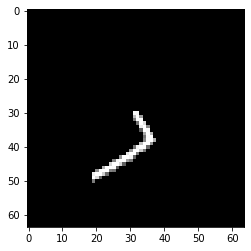

In [77]:
from IPython.display import HTML
HTML(save_trajectory_video(labels, '', 64, 64))

In [111]:
labels_extreme = np.where(np.bitwise_or(labels < 125, labels > 129), labels, np.zeros_like(labels))

In [112]:
labels_extreme[labels_extreme == 141]

array([141, 141, 141, 141, 141], dtype=uint8)

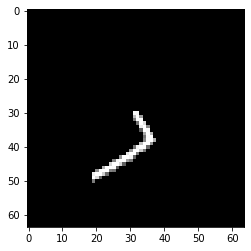

In [113]:
HTML(save_trajectory_video(labels_extreme, '', 64, 64))